In [1]:
import random
import time
import pickle
import sys
import json
import re
import string
import collections
import codecs
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3

from sklearn import feature_extraction

import gensim
from gensim import corpora
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize

import pygraphviz
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

pd.options.mode.chained_assignment = None  # default='warn'

## 1 - Fragebogen

#### Reading fragebogen information

In [2]:
fb_original = pd.read_pickle('./fb_original.pickle')

In [3]:
fb_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 1 to 109
Data columns (total 5 columns):
titel             109 non-null object
number            109 non-null object
headwords         109 non-null object
series            109 non-null object
headwords_list    109 non-null object
dtypes: object(5)
memory usage: 5.1+ KB


In [4]:
fb_original.head(10)

titel number  \
nummer                                                             
1                                  Fragebogen 1: Kopf (1)      1   
2                        Fragebogen 2: Die Osterwoche (1)      2   
3                        Fragebogen 3: Die Osterwoche (2)      3   
4                                  Fragebogen 4: Kopf (2)      4   
5       Fragebogen 5: Zeit zwischen Ostern und Fronlei...      5   
6         Fragebogen 6: Menschl. Haar und Bart (= Kopf 3)      6   
7                              Fragebogen 7: Hochzeit (1)      7   
8                              Fragebogen 8: Hochzeit (2)      8   
9                              Fragebogen 9: Hochzeit (3)      9   
10                            Fragebogen 10: Hochzeit (4)     10   

                                    headwords      series  \
nummer                                                      
1                                        Kopf         (1)   
2                              Die Osterwoche         (1)   
3                              Die Osterwoche         (2)   
4                                        Kopf         (2)   
5       Zeit zwischen Ostern und Fronleichnam               
6                      Menschl. Haar und Bart  (= Kopf 3)   
7                                    Hochzeit         (1)   
8                                    Hochzeit         (2)   
9                                    Hochzeit         (3)   
10                                   Hochzeit         (4)   

                      headwords_list  
nummer                                
1                             [kopf]  
2                       [osterwoche]  
3                       [osterwoche]  
4                             [kopf]  
5       [ostern, zeit, fronleichnam]  
6              [bart, menschl, haar]  
7                         [hochzeit]  
8                         [hochzeit]  
9                         [hochzeit]  
10                        [hochzeit]

In [5]:
#https://matplotlib.org/2.0.2/api/colors_api.html

G = nx.Graph()

for concept_list in fb_original.headwords_list:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in fb_original.number:
    G.add_node(questionnaire, color='yellow')
    
for idn in fb_original.index:
    for concept in fb_original.loc[idn, 'headwords_list']:
        G.add_edge(concept, fb_original.loc[idn, 'number'], length = 10)

In [6]:
#print(G.nodes)
print(G.edges)

[('kopf', '1'), ('kopf', '4'), ('osterwoche', '2'), ('osterwoche', '3'), ('ostern', '5'), ('ostern', '72'), ('zeit', '5'), ('zeit', '54'), ('zeit', '68'), ('zeit', '72'), ('fronleichnam', '5'), ('bart', '6'), ('menschl', '6'), ('haar', '6'), ('hochzeit', '7'), ('hochzeit', '8'), ('hochzeit', '9'), ('hochzeit', '10'), ('hochzeit', '11'), ('ohr', '12'), ('nase', '12'), ('auge', '13'), ('flur', '14'), ('flur', '15'), ('besiedelung', '14'), ('besiedelung', '15'), ('feldbestellung', '16'), ('feldbestellung', '17'), ('feldbestellung', '18'), ('feldbestellung', '19'), ('feld', '16'), ('feld', '17'), ('feld', '18'), ('feld', '19'), ('körper', '20'), ('körper', '21'), ('körper', '22'), ('körper', '23'), ('körperteil', '24'), ('körperteil', '77'), ('körperteil', '78'), ('hautkrankheit', '25'), ('hautkrankheit', '26'), ('hautkrankheit', '27'), ('brotbacken', '28'), ('brotbacken', '29'), ('brotbacken', '30'), ('weißgebäck', '31'), ('gliedmaß', '32'), ('arm', '32'), ('arm', '33'), ('hand', '34'), (

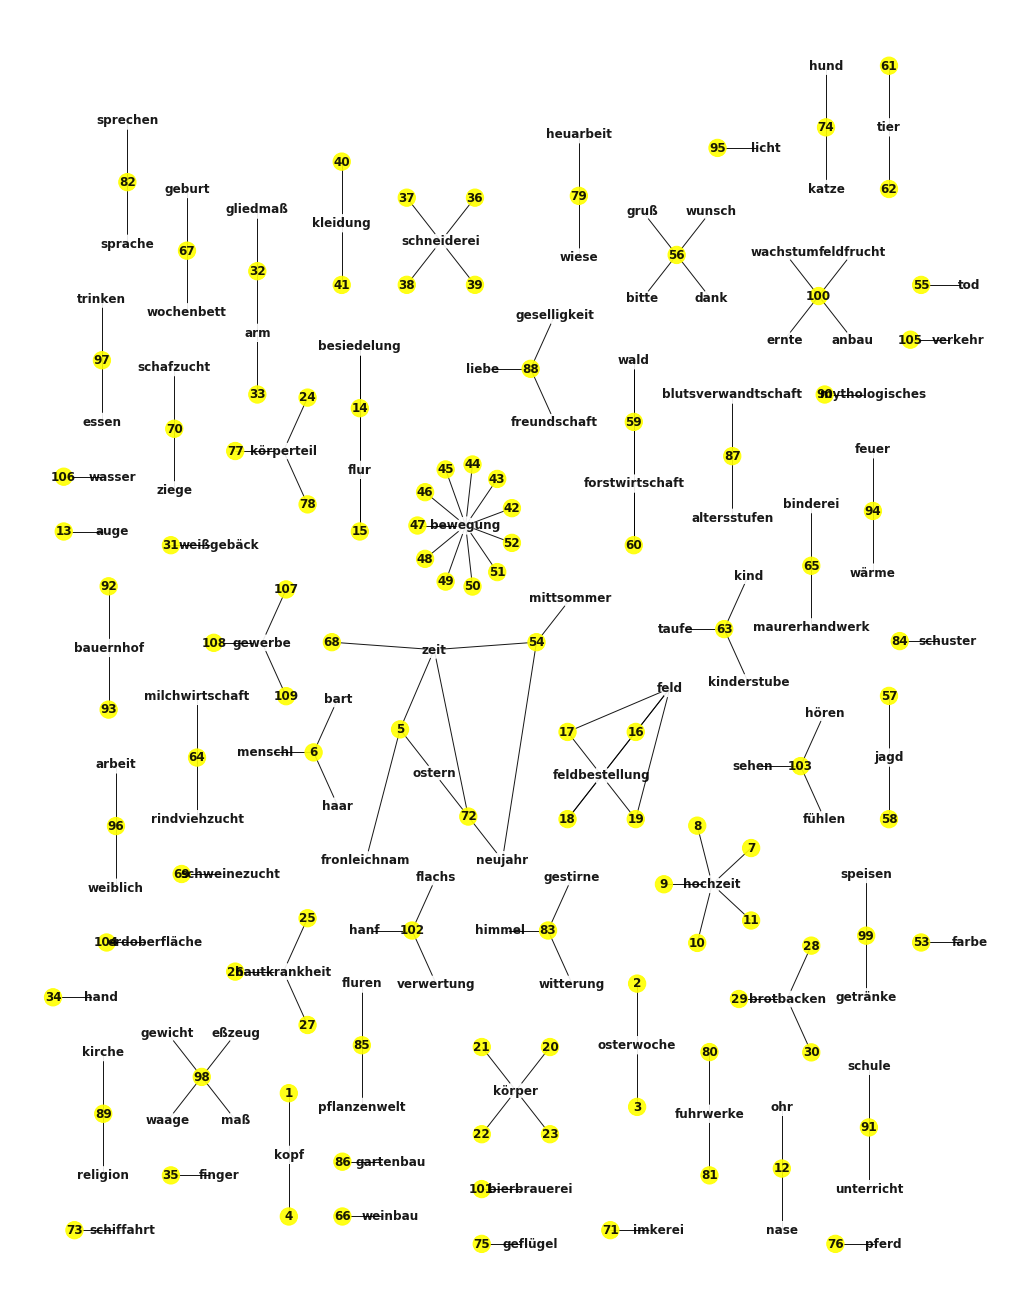

In [7]:
#https://stackoverflow.com/questions/48240021/alter-edge-length-and-cluster-spacing-in-networkx-matplotlib-force-graph
#if Win: https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# https://stackoverflow.com/questions/4571067/installing-pygraphviz-on-windows?rq=1
#if Anaconda: conda install graphviz pygraphviz -c alubbock
#pip install --global-option=build_ext --global-option="-IC:\Program Files\<path>\Graphviz2.38\include" --global-option="-LC:\Program Files\Graphviz2.38\lib\release\lib" pygraphviz

plt.figure(figsize=(14,18))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        #width=5,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        font_weight='bold', 
        #font_color='white',
       )


plt.show()

## 2 - Frage

#### Reading frage information

In [8]:
frage = pd.read_pickle('./frage.pickle')

In [9]:
frage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16738 entries, 0 to 16743
Data columns (total 7 columns):
fragebogen_id      16738 non-null int64
nummer             16738 non-null object
original_frage     16738 non-null object
main_theme         16738 non-null object
question_words     16738 non-null object
semantic_words     16738 non-null object
syntactic_words    16738 non-null object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


In [11]:
frage.head(10)

fragebogen_id nummer                                     original_frage  \
0              1     A1           Kopf: Kopf, Haupt; auch scherzh./übertr.   
1              1     A2  Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...   
2              1     A3  Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...   
3              1     A4  Kopf: schöner, ebenmäßig gebauter Kopf (Christ...   
4              1    A4a                Kopf: häßlicher, unebenmäßiger Kopf   
5              1     A5                      Kopf: großer Kopf; großkopfig   
6              1    A5a                                   Kopf: Wasserkopf   
7              1     A6                                 Kopf: kleiner Kopf   
8              1     A7                       Kopf: oben zugespitzter Kopf   
9              1     A8                                  Kopf: langer Kopf   

  main_theme                                     question_words  \
0     [kopf]              [übertragen, scherzhaft, kopf, haupt]   
1     [kopf]  [stehen, redensarten, haupt, bedeutung, zerspr...   
2     [kopf]  [jemand, haupt, redensarten, übertragen, offen...   
3     [kopf]  [schön, tituskopf, ebenmäßig, gebaut, christus...   
4     [kopf]                       [häßlich, unebenmäßig, kopf]   
5     [kopf]                           [großkopfig, kopf, groß]   
6     [kopf]                                 [wasserkopf, kopf]   
7     [kopf]                                      [kopf, klein]   
8     [kopf]                           [zugespitzt, oben, kopf]   
9     [kopf]                                       [lang, kopf]   

                                      semantic_words           syntactic_words  
0              [übertragen, scherzhaft, kopf, haupt]                        []  
1  [stehen, haupt, zerspringen, möchten, kopf, ve...  [redensarten, bedeutung]  
2  [jemand, haupt, übertragen, offen, fein, vergl...             [redensarten]  
3  [schön, tituskopf, ebenmäßig, gebaut, christus...                        []  
4                       [häßlich, unebenmäßig, kopf]                        []  
5                           [großkopfig, kopf, groß]                        []  
6                                 [wasserkopf, kopf]                        []  
7                                      [kopf, klein]                        []  
8                           [zugespitzt, oben, kopf]                        []  
9                                       [lang, kopf]                        []

#### Examining the common concepts

In [12]:
concepts = []
for entry in frage.syntactic_words.values:  
    for concept in entry:
        concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(200)

[('komposita', 1661),
 ('redensarten', 1491),
 ('beispiel', 967),
 ('bedeutung', 866),
 ('plural', 697),
 ('deminutiv', 478),
 ('femininum', 414),
 ('adjektiv', 282),
 ('verba', 263),
 ('ableitungen', 218),
 ('synonyme', 198),
 ('wendungen', 189),
 ('ab', 183),
 ('grundwort', 87),
 ('substantiva', 74),
 ('bestimmungswort', 68),
 ('et', 47),
 ('en', 32),
 ('partizip', 31),
 ('perfekt', 30),
 ('singular', 29),
 ('verb', 12),
 ('akkusativ', 12),
 ('dativ', 4),
 ('konjunktiv', 4)]

In [13]:
concepts = []
for entry in frage.semantic_words.values:  
    for concept in entry:
        concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(500)

[('gewerbe', 609),
 ('körper', 479),
 ('ausdrücke', 401),
 ('besonderer', 380),
 ('wild', 343),
 ('feld', 321),
 ('wer', 298),
 ('gehen', 289),
 ('kopf', 274),
 ('bezeichnung', 270),
 ('jagd', 261),
 ('waldbaum', 256),
 ('ähnlich', 243),
 ('kommen', 234),
 ('name', 232),
 ('schneiderei', 214),
 ('teil', 204),
 ('bauer', 204),
 ('sonstig', 189),
 ('form', 180),
 ('auge', 176),
 ('baum', 173),
 ('gut', 171),
 ('eisenbahn', 168),
 ('holz', 166),
 ('üblich', 162),
 ('kind', 160),
 ('übertragen', 159),
 ('heißen', 155),
 ('art', 150),
 ('hautkrankh', 144),
 ('mensch', 141),
 ('brot', 141),
 ('vogel', 141),
 ('pferd', 138),
 ('wetter', 135),
 ('haut', 135),
 ('geschlecht', 133),
 ('lassen', 132),
 ('wagenteil', 128),
 ('hand', 127),
 ('geben', 125),
 ('reden', 124),
 ('klein', 123),
 ('gewässer', 123),
 ('groß', 122),
 ('sei', 122),
 ('rind', 120),
 ('bräuche', 118),
 ('wann', 117),
 ('fahren', 114),
 ('volksglaube', 113),
 ('stelle', 112),
 ('dergleichen', 112),
 ('füg', 110),
 ('schiffahrt

#### Drawing the Graphs of specific Fragebogen / Frage concepts

In [15]:
#filtered = frage[frage.fragebogen_id <= 4]

#cfilter = "kopf"
#cfilter = "schwarz"
#cfilter = "suppe"
cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

In [16]:
G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)

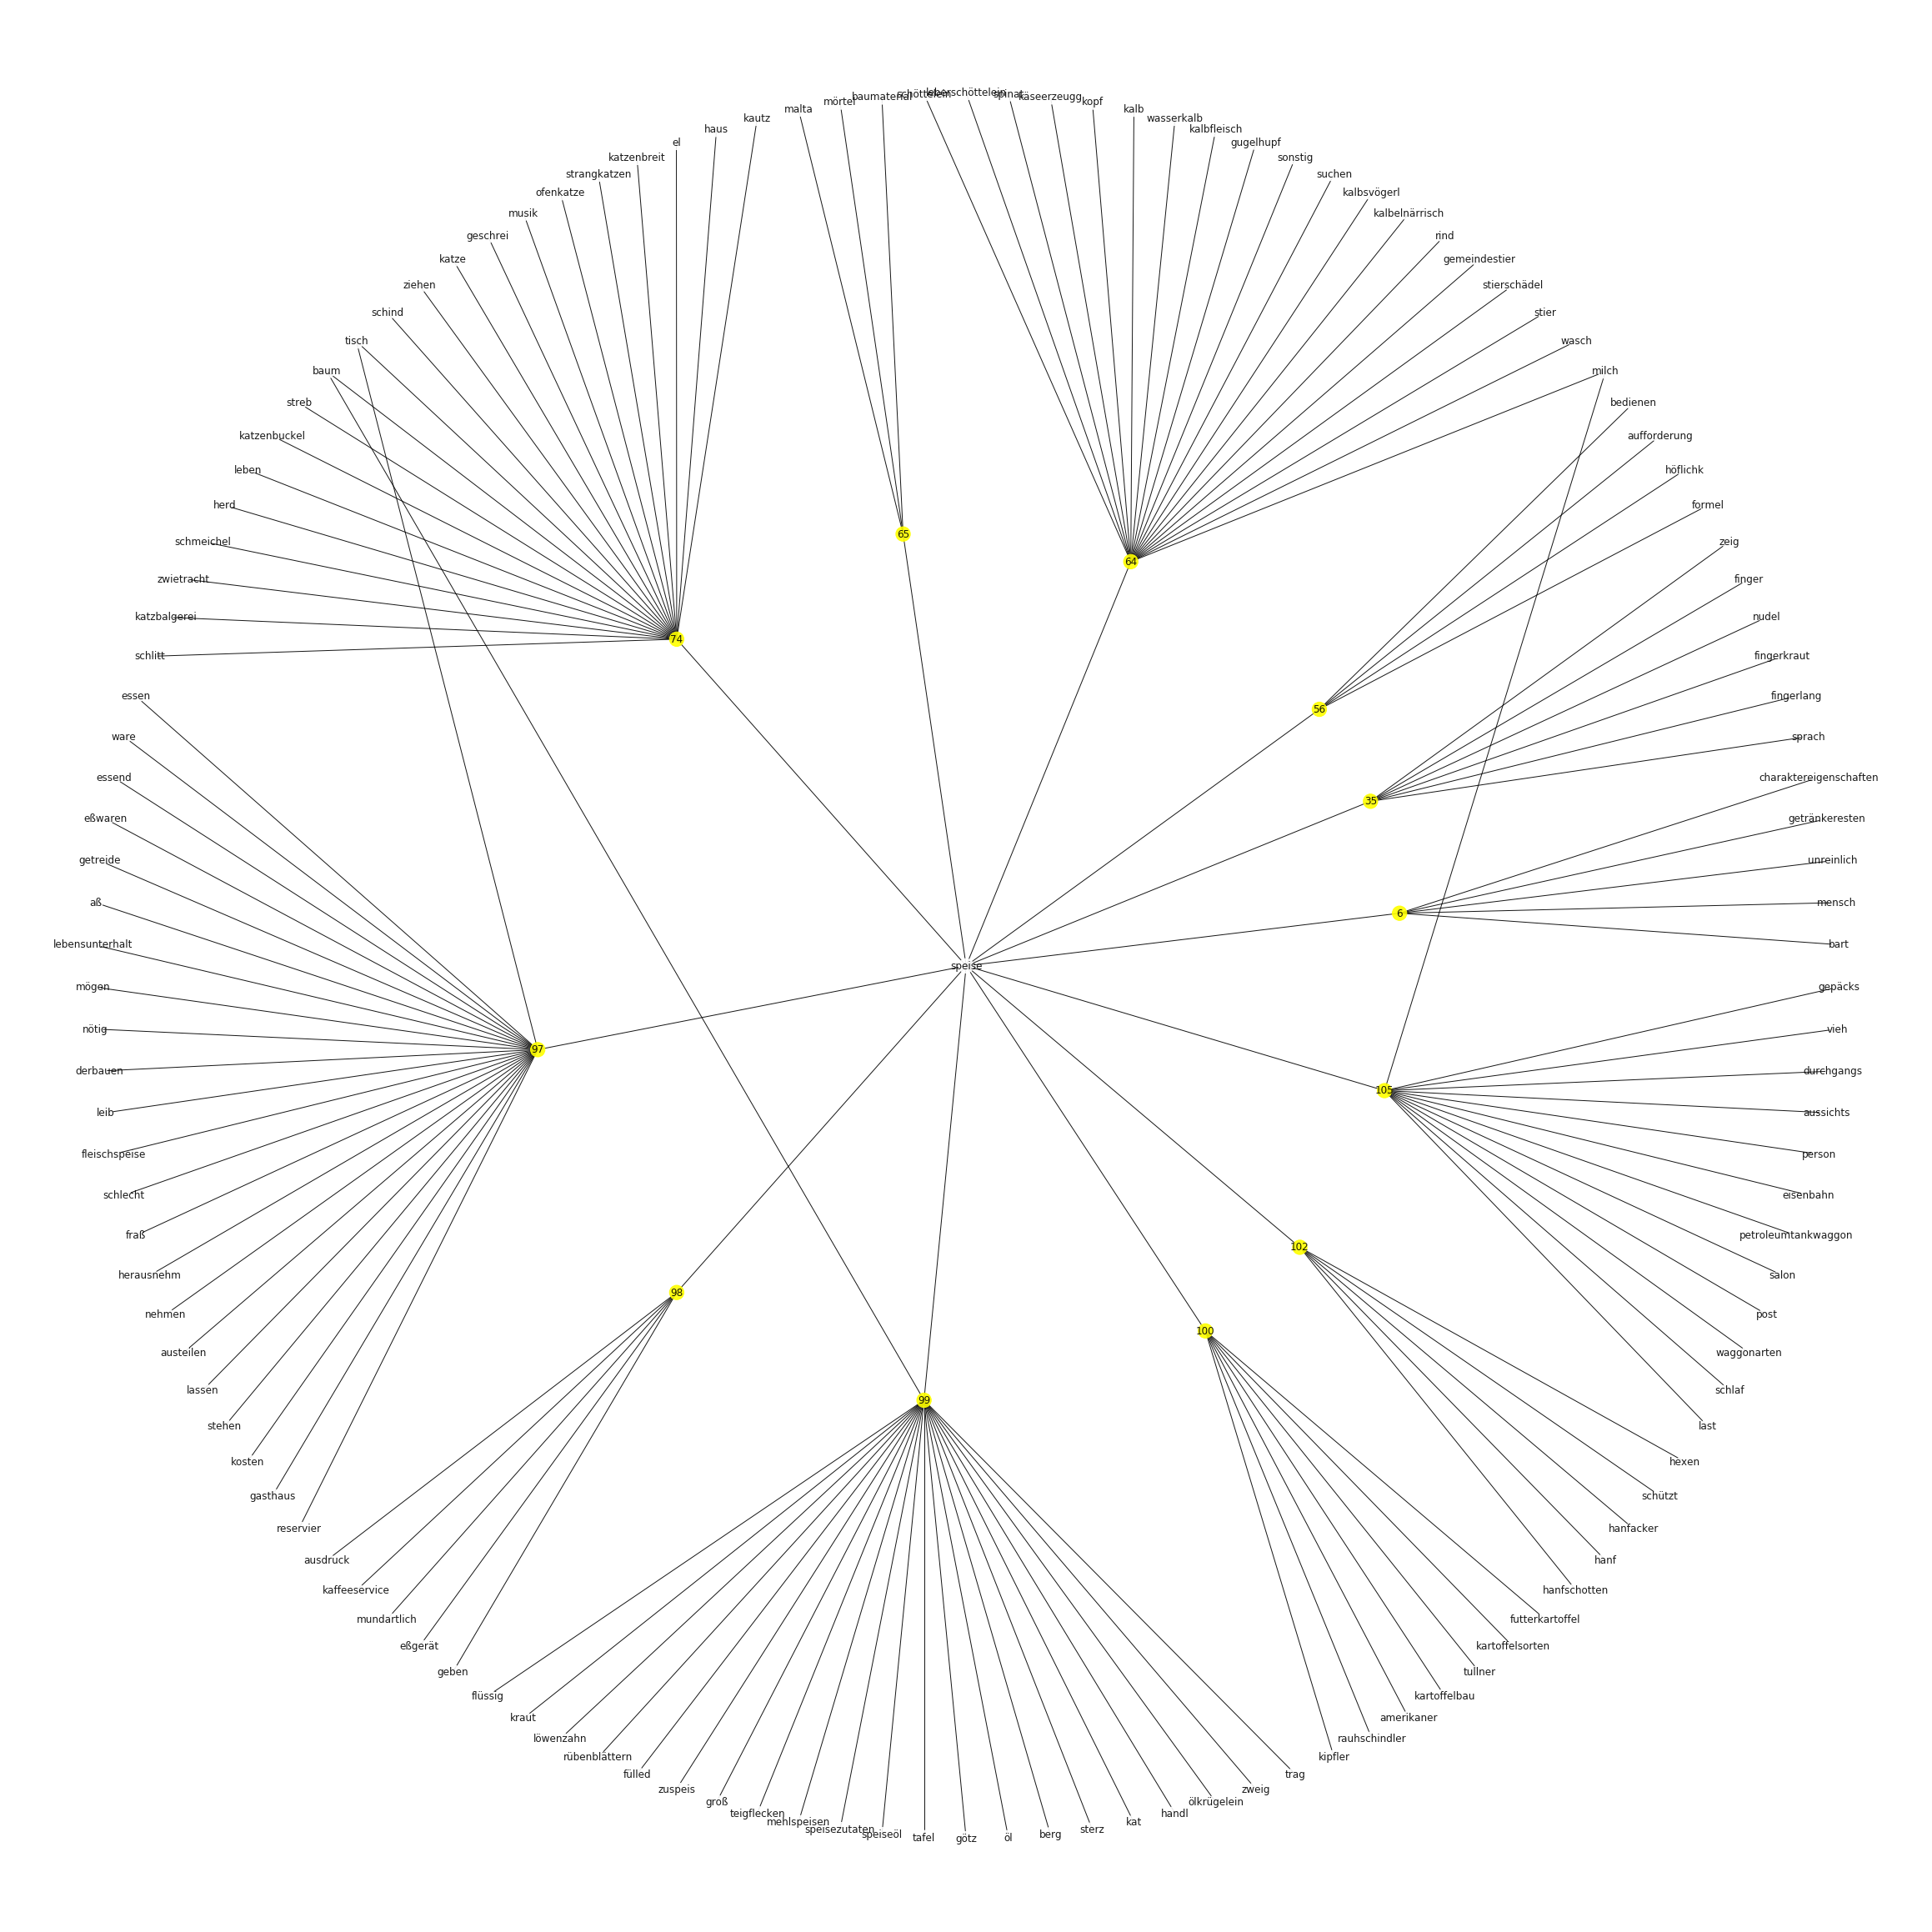

In [17]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        width=1,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        #font_weight='bold', 
        #font_color='white',
       )


#plt.show()


plt.savefig('./outputs/{}.png'.format(cfilter), bbox_inches='tight')

### Topic Modeling with the concepts

Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.

In [18]:
all_concepts = []
for entry in frage.semantic_words.values:
    all_concepts.append(entry)
    
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(all_concepts)
#dictionary.filter_extremes(no_below=1, no_above=0.9)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_concepts]

Running LDA Model

Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few parameters as input which are explained in the above section. The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [19]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
num_topics = 8

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50)

In [20]:
ldamodel.print_topics(num_topics=num_topics, num_words=20)
#ldamodel.show_topics(10)

[(0,
  '0.009*"feuer" + 0.009*"geschlecht" + 0.009*"fuß" + 0.007*"gasthaus" + 0.007*"säugetiere" + 0.005*"bau" + 0.005*"wein" + 0.005*"liebe" + 0.005*"dreschen" + 0.005*"fenster" + 0.004*"mauerwerk" + 0.004*"rindfleischsorte" + 0.004*"maurerarbeit" + 0.004*"stall" + 0.004*"gottesdienst" + 0.004*"geschwür" + 0.003*"dick" + 0.003*"zaun" + 0.003*"korn" + 0.003*"hautschwellg"'),
 (1,
  '0.013*"wer" + 0.010*"besonderer" + 0.009*"teil" + 0.009*"ausdrücke" + 0.009*"kommen" + 0.006*"schauen" + 0.005*"stehen" + 0.005*"wild" + 0.005*"bedeuten" + 0.005*"gespann" + 0.005*"zugpferd" + 0.005*"wohnhaus" + 0.004*"aussprache" + 0.004*"gartenblume" + 0.004*"schiffsteil" + 0.004*"hautkrankh" + 0.004*"name" + 0.004*"wohnstube" + 0.004*"mühl" + 0.003*"haar"'),
 (2,
  '0.010*"gut" + 0.007*"reden" + 0.007*"mehlspeisen" + 0.006*"dergleichen" + 0.006*"mensch" + 0.005*"sei" + 0.005*"bezeichnung" + 0.005*"schlecht" + 0.004*"wild" + 0.004*"kind" + 0.004*"lebensalter" + 0.004*"brot" + 0.004*"obst" + 0.004*"bauer" 

In [21]:
topics_matrix = ldamodel.show_topics(formatted=False, num_words=20)
dic_topics = {num:words for num, words in topics_matrix}
df = pd.DataFrame(dic_topics)
df = df.reindex(sorted(df.columns), axis=1)
df.head(20)
#{num:words for num, words in topics_matrix}

0                            1  \
0               (feuer, 0.009082311)           (wer, 0.012774862)   
1          (geschlecht, 0.009078211)    (besonderer, 0.010151127)   
2                 (fuß, 0.008512012)          (teil, 0.009034031)   
3           (gasthaus, 0.0071435883)      (ausdrücke, 0.00899935)   
4         (säugetiere, 0.0065924693)        (kommen, 0.008728759)   
5                (bau, 0.0054341545)      (schauen, 0.0055398364)   
6               (wein, 0.0052916333)        (stehen, 0.005464789)   
7              (liebe, 0.0052847466)          (wild, 0.005378599)   
8           (dreschen, 0.0052276966)     (bedeuten, 0.0052002864)   
9            (fenster, 0.0046343347)      (gespann, 0.0048679058)   
10         (mauerwerk, 0.0044203545)     (zugpferd, 0.0048679058)   
11  (rindfleischsorte, 0.0043446277)      (wohnhaus, 0.004570625)   
12      (maurerarbeit, 0.0037897846)    (aussprache, 0.004472931)   
13             (stall, 0.0037103386)  (gartenblume, 0.0042569237)   
14       (gottesdienst, 0.003673191)  (schiffsteil, 0.0039498685)   
15          (geschwür, 0.0036197256)   (hautkrankh, 0.0039318632)   
16                (dick, 0.00342162)         (name, 0.0038785117)   
17              (zaun, 0.0033022724)    (wohnstube, 0.0037610077)   
18               (korn, 0.003261814)         (mühl, 0.0035973538)   
19       (hautschwellg, 0.003218446)         (haar, 0.0034250787)   

                                 2                                 3  \
0               (gut, 0.009999638)              (flachs, 0.00830501)   
1            (reden, 0.0074283998)               (bier, 0.008093072)   
2       (mehlspeisen, 0.007008514)            (schule, 0.0077149356)   
3       (dergleichen, 0.006394167)        (hanfarbeit, 0.0068685994)   
4            (mensch, 0.006125568)              (holz, 0.0067968555)   
5                 (sei, 0.0050413)          (verwandte, 0.006707412)   
6       (bezeichnung, 0.004866557)           (trinken, 0.0054515144)   
7         (schlecht, 0.0046839034)                (hören, 0.0051116)   
8              (wild, 0.004424677)                (tod, 0.004340113)   
9             (kind, 0.0042783013)         (lehrmittel, 0.004324216)   
10     (lebensalter, 0.0042379843)              (schaf, 0.004222634)   
11             (brot, 0.004110077)             (knecht, 0.003972361)   
12            (obst, 0.0041072546)    (küchengeschirr, 0.0036823943)   
13           (bauer, 0.0039885705)        (rinderleben, 0.003511269)   
14       (ausdrücke, 0.0039819684)             (hühner, 0.003468481)   
15       (übertragen, 0.003935096)         (malzbereitg, 0.00343961)   
16          (eßgerät, 0.003875248)  (frauenhandarbeit, 0.0033997807)   
17  (volkskundliches, 0.003811344)           (treiben, 0.0033786877)   
18           (milch, 0.0037726457)             (taufe, 0.0033297115)   
19         (ähnlich, 0.0037106636)                (sau, 0.003326052)   

                              4                                5  \
0           (kopf, 0.010280053)            (gewerbe, 0.14603895)   
1         (körper, 0.009935833)         (waldbaum, 0.0093032075)   
2         (wetter, 0.009745186)              (gerät, 0.00905505)   
3           (pferd, 0.00944655)       (bierbereitg, 0.006786877)   
4         (vogel, 0.0077688973)          (bräuche, 0.0067594605)   
5   (volksglaube, 0.0073914407)        (werkzeuge, 0.0063093365)   
6          (fisch, 0.006677266)            (brücke, 0.005922555)   
7         (bauch, 0.0063173193)         (zunfttag, 0.0052952664)   
8          (name, 0.0062507815)    (zunftheiliger, 0.0052952664)   
9     (besonderer, 0.005779792)           (weinbau, 0.004363246)   
10          (heu, 0.0055582807)         (schlagen, 0.0038389536)   
11   (verschieden, 0.005240816)       (waldarbeit, 0.0034723221)   
12     (hausdach, 0.0048963656)             (holz, 0.0029541692)   
13     (heuernte, 0.0047503887)      (rohmaterial, 0.0028913894)   
14       (schwein, 0.004741972)  (schulunterricht, 0

In [22]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.save_html(p, './outputs/lda.html')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Using Word Embeddings

[trained model 1](https://devmount.github.io/GermanWordEmbeddings/#download)  
[trained model 2](https://deepset.ai/german-word-embeddings)

In [23]:
# get trained model, files without a suffix, .bin or .model are treated as binary files
trained_model = gensim.models.KeyedVectors.load_word2vec_format('../German_Word2vec/german.model', binary=True)
# remove original vectors to free up memory
trained_model.init_sims(replace=True)

Different [metrics](http://mkusner.github.io/publications/WMD.pdf)

In [24]:
print(trained_model.similarity('kopf', 'blau'))
print(trained_model.distance('kopf', 'blau'))

0.4494617
0.5505383014678955


In [25]:
words = ['blau', 'rot', 'kopf', 'Gewerbe']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in trained_model.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('rot', 0.8281903862953186)
('gruen', 0.7959476709365845)
('gelb', 0.7838804721832275)
('orange', 0.7746740579605103)
('grau', 0.7626761198043823)
('Blau', 0.7593175172805786)
('schwarz', 0.755070149898529)
('braun', 0.7448124885559082)
('tuerkis', 0.7368776202201843)
('rosa', 0.7332463264465332)
('lila', 0.7257266640663147)
('rot_gelb', 0.7144009470939636)
('Hellblau', 0.7142020463943481)
('gelb_blau', 0.7131950855255127)
('blau_rot', 0.7092214822769165)
('dunkelblau', 0.707565188407898)
('Gelb_Orange', 0.7064606547355652)
('pink', 0.7047414779663086)
('weiss_rot', 0.7010555267333984)
('rot_blau', 0.6987532377243042)

word: rot
('gelb', 0.8350189924240112)
('gruen', 0.8290626406669617)
('blau', 0.8281903266906738)
('schwarz', 0.7826082706451416)
('orange', 0.7713059186935425)
('grau', 0.7314903736114502)
('rot_gelb', 0.7234443426132202)
('rote', 0.7225121259689331)
('braun', 0.7214125990867615)
('lila', 0.7197442650794983)
('violett', 0.7078529596328735)
('Blau', 0.7019246

In [26]:
list_words = ['blau', 'rot', 'feld', 'grün', 'gelb']
print(trained_model.doesnt_match(list_words))

feld


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [27]:
for result in trained_model.most_similar(positive=['frau', 'blau'], negative=['mann']):
    print(result)

('rosa', 0.6545881032943726)
('orange', 0.6302927732467651)
('gruen', 0.619945764541626)
('rot', 0.619027316570282)
('Glitzer', 0.6155712604522705)
('lila', 0.6148803234100342)
('grau', 0.6142277717590332)
('pink', 0.6076772212982178)
('knallrot', 0.6024129390716553)
('knallige_Farben', 0.5976543426513672)


#### Training our own model

In [28]:
sentences = []
for sentence in frage.semantic_words.values:
    sentences.append(sentence)

own_model = gensim.models.Word2Vec(sentences, min_count=1)

In [29]:
words = ['blau', 'rot', 'kopf']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in own_model.wv.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))
    


word: blau
('eisenbahn', 0.7913720607757568)
('weit', 0.7817637324333191)
('wer', 0.7794713377952576)
('name', 0.7713218927383423)
('gehen', 0.7712490558624268)
('besonderer', 0.7693138122558594)
('beziehen', 0.7680807113647461)
('form', 0.7654412984848022)
('teil', 0.7644141316413879)
('pferd', 0.7638348937034607)
('verwenden', 0.7602744698524475)
('ausdrücke', 0.7592841386795044)
('kommen', 0.7585955262184143)
('bauer', 0.7578226327896118)
('art', 0.7560588121414185)
('füg', 0.7551479935646057)
('bezeichnung', 0.755110502243042)
('heuernte', 0.7544730305671692)
('gewerbe', 0.7505097389221191)
('feld', 0.7503413558006287)

word: rot
('waldbaum', 0.8164565563201904)
('bauer', 0.814172625541687)
('gehen', 0.813940167427063)
('baum', 0.8135977387428284)
('ausdrücke', 0.8105874061584473)
('bezeichnung', 0.8090171217918396)
('volkstümlich', 0.8076310753822327)
('gewässer', 0.8050897121429443)
('ähnlich', 0.8050390481948853)
('feld', 0.8049089312553406)
('gewerbe', 0.8034186959266663)
('fo

#### Expanding a graph with similar words

In [30]:
#cfilter = "kopf"
#cfilter = "schwarz"
cfilter = "suppe"
#cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

In [31]:
G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        for w in own_model.wv.most_similar(concept, topn=5):
            G.add_node(w[0], color='white')
            G.add_edge(concept, w[0], length = 10)        
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)

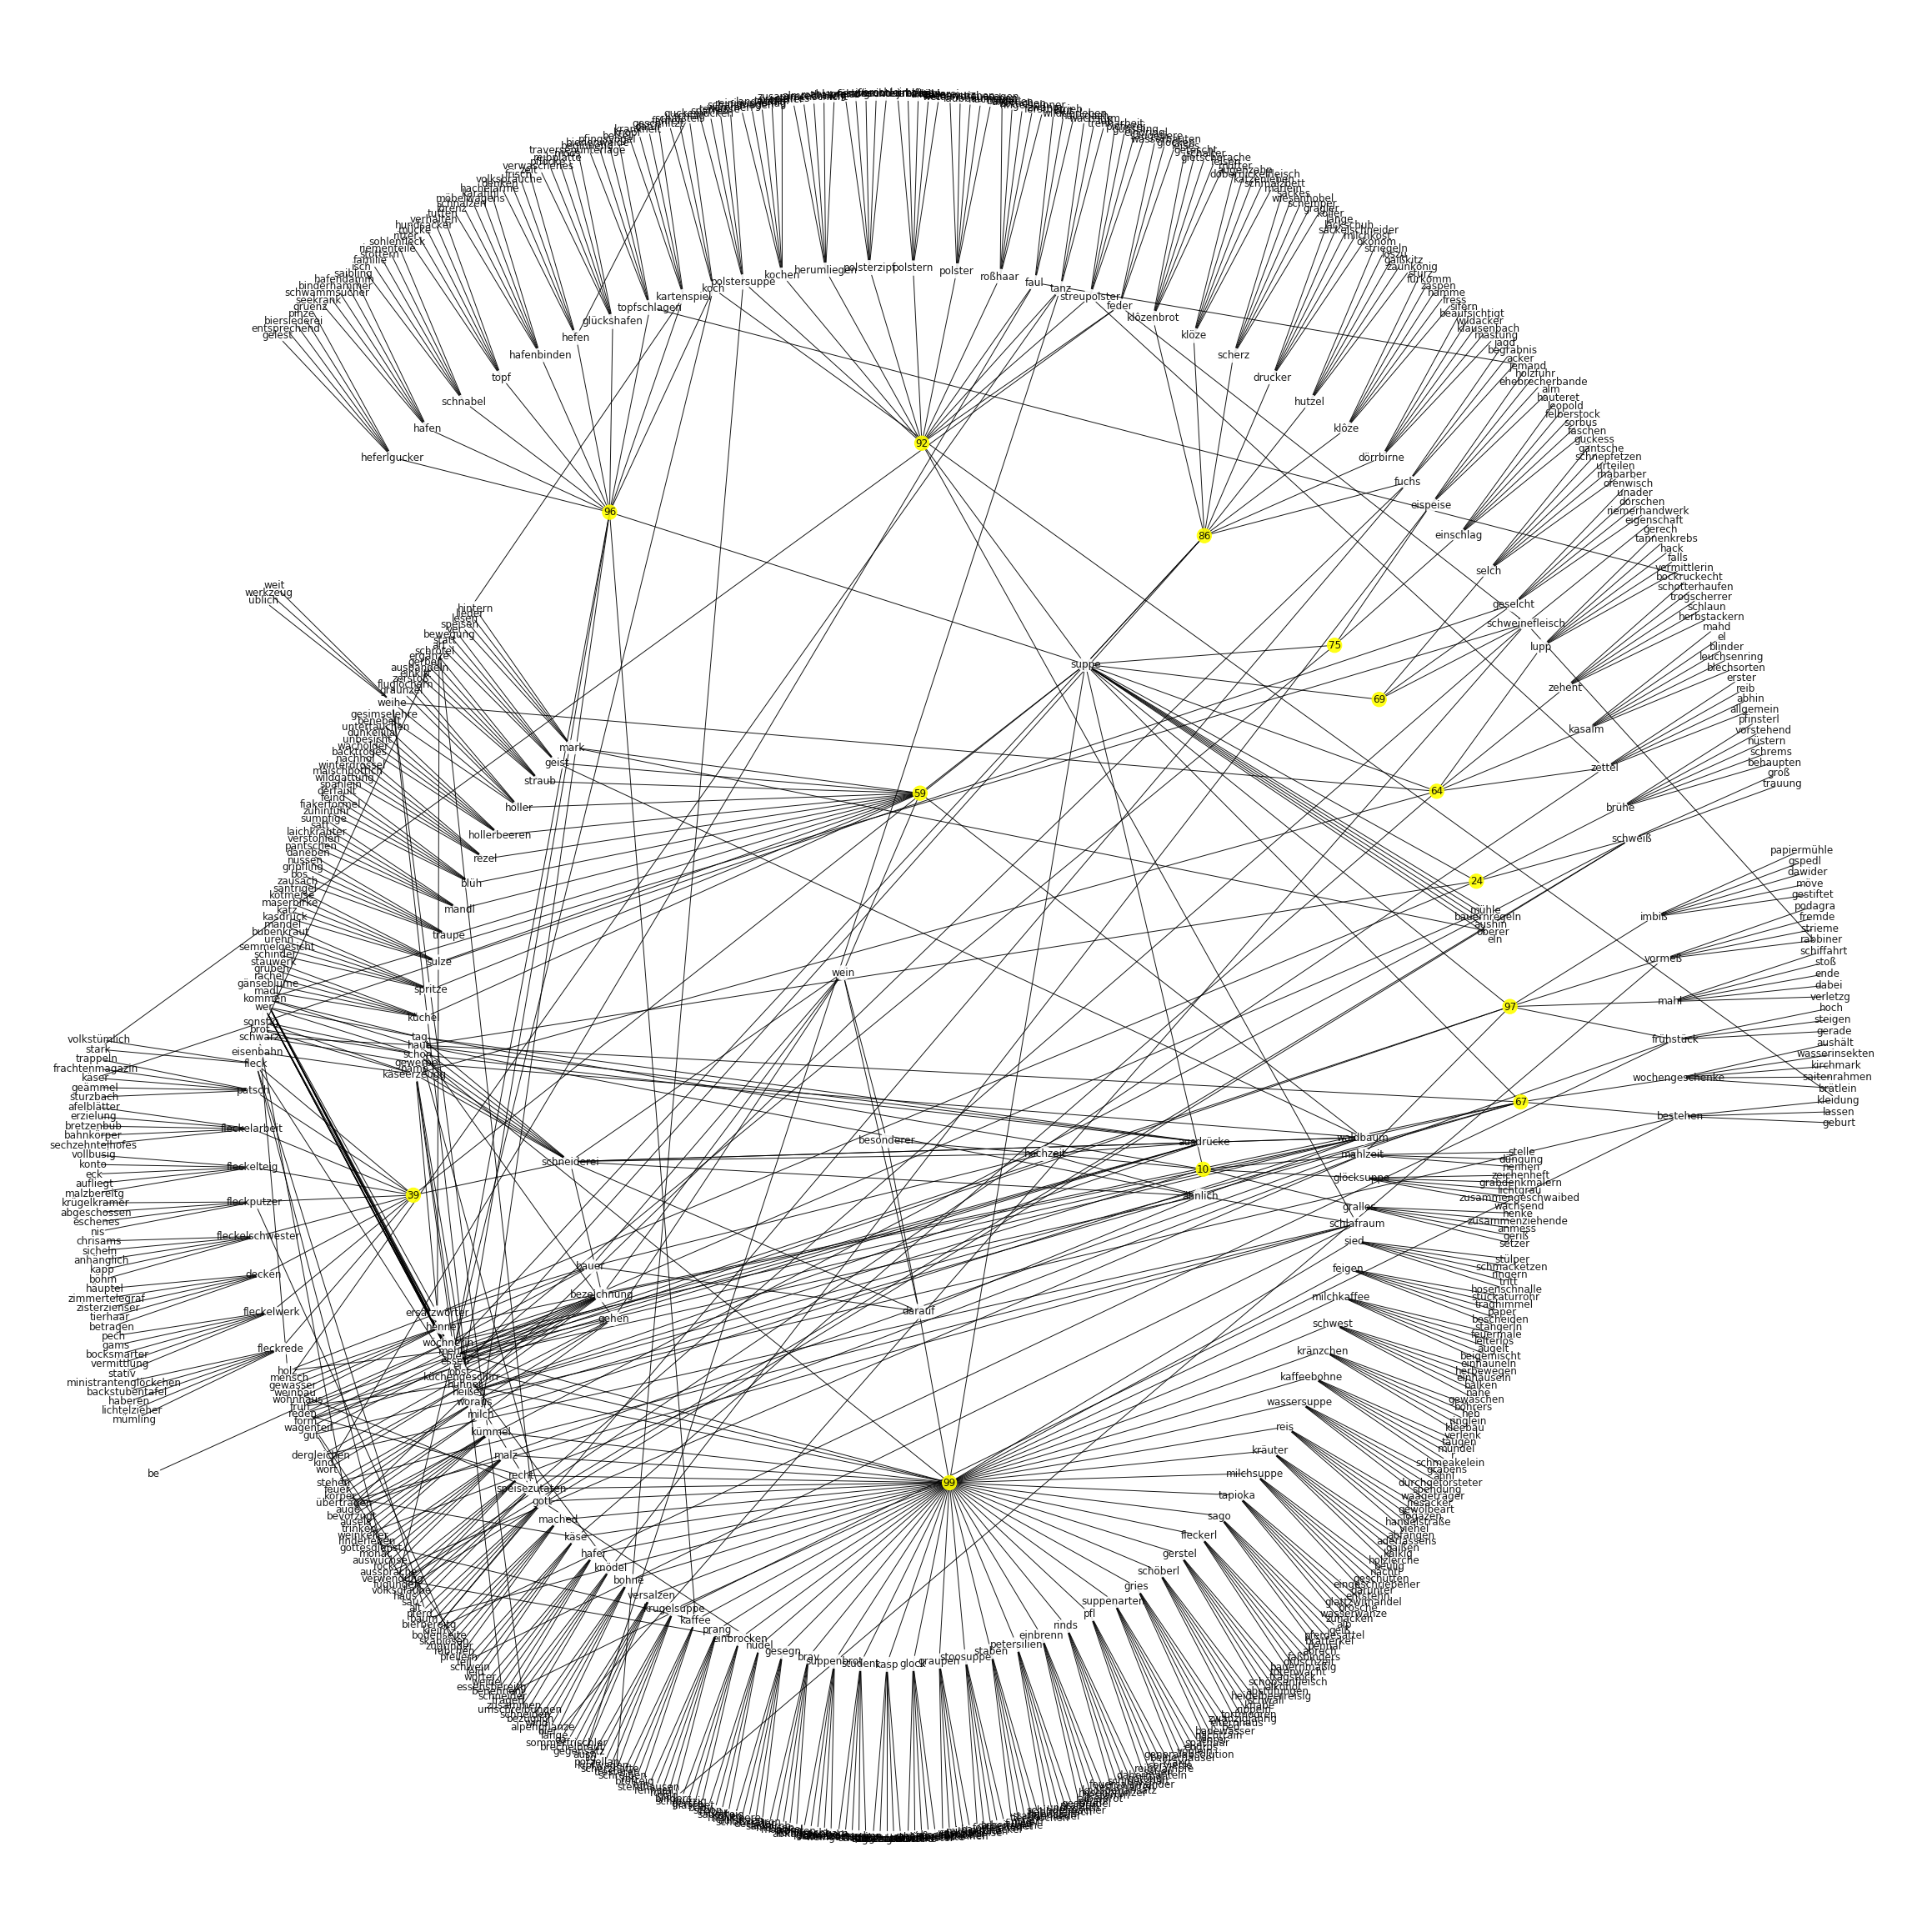

In [32]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        width=1,
        alpha=0.9,
        cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        #font_weight='bold', 
        #font_color='white',
       )

#plt.show()

plt.savefig('./outputs/{}_plus_similar.png'.format(cfilter), bbox_inches='tight')

### Using [Patern.de](https://www.clips.uantwerpen.be/pages/pattern-de)

In [78]:
import pattern.de as pde

In [79]:
print(pde.gender('Katze'))
print(pde.article('Katze', pde.DEFINITE, gender=pde.FEMALE, role=pde.OBJECT))
print(pde.singularize('Katzen'))
print(pde.pluralize('Katze'))
print(pde.conjugate('war', pde.INFINITIVE))
print(pde.conjugate('war', pde.PRESENT, 1, pde.SG, mood=pde.SUBJUNCTIVE))
print(pde.predicative('neugierige')) 
print(pde.attributive('neugierig', gender=pde.FEMALE))
print(pde.attributive('neugierig', gender=pde.FEMALE, role=pde.OBJECT))
print(pde.attributive('neugierig', gender=pde.FEMALE, role=pde.INDIRECT, article="die"))

f
die
Katze
Katzen
sein
sei
neugierig
neugierige
neugierige
neugierigen


In [80]:
s = pde.parse('Die Katze liegt auf der Matte.', tagset="STTS")
for sentence in s.split():
    print(sentence)

[['Die', 'ARTDEF', 'O', 'O'], ['Katze', 'NN', 'B-NP', 'O'], ['liegt', 'VVFIN', 'B-PP', 'B-PNP'], ['auf', 'APPR', 'B-NP', 'I-PNP'], ['der', 'ARTDEF', 'O', 'O'], ['Matte', 'NN', 'B-NP', 'O'], ['.', 'S', 'O', 'O']]


/usr/local/lib/python3.6/dist-packages/pattern/text/__init__.py:625: DeprecationWarning: generator '_read' raised StopIteration
  dict.update(self, (x.split(" ")[:2] for x in _read(self._path) if len(x.split(" ")) > 1))
/usr/local/lib/python3.6/dist-packages/pattern/text/__init__.py:868: DeprecationWarning: generator '_read' raised StopIteration
  list.extend(self, (x.split() for x in _read(self._path)))


In [81]:
s = pde.parse('Die Katze liegt auf der Matte.',)
for sentence in s.split():
    print(sentence)

[['Die', 'DT', 'B-NP', 'O'], ['Katze', 'NN', 'I-NP', 'O'], ['liegt', 'VB', 'B-VP', 'O'], ['auf', 'IN', 'B-PP', 'B-PNP'], ['der', 'DT', 'B-NP', 'I-PNP'], ['Matte', 'NN', 'I-NP', 'I-PNP'], ['.', '.', 'O', 'O']]


Dividing the concepts by gramatical classes

In [82]:
def onlynouns(l):
    nouns = [w for w in l if pde.parse(w).split('/')[1] == 'NN']
    return(nouns)

def onlyverbs(l):
    verbs = [w for w in l if pde.parse(w).split('/')[1] == 'VB']
    return(verbs)

In [83]:
frage_POS = pd.concat([frage.semantic_words.apply(onlynouns),
                       frage.semantic_words.apply(onlyverbs)], axis=1)

frage_POS.columns = ['NN','VB']
frage_POS.head(10)

/usr/local/lib/python3.6/dist-packages/pattern/text/__init__.py:772: DeprecationWarning: generator '_read' raised StopIteration
  list.extend(self, (x.split() for x in _read(self._path)))


NN                 VB
0                           [kopf]                 []
1   [zerspringen, kopf, vergleich]  [stehen, möchten]
2     [vergleich, verdrehen, kopf]                 []
3  [tituskopf, christuskopf, kopf]                 []
4                           [kopf]                 []
5                           [kopf]                 []
6               [wasserkopf, kopf]                 []
7                           [kopf]                 []
8               [zugespitzt, kopf]                 []
9                           [kopf]                 []

### Using [PyGermanet](https://pypi.org/project/pygermanet/)

In [ ]:
from pygermanet import load_germanet, Synset
from scipy.stats.stats import pearsonr


In [106]:
from pygermanet import load_germanet
gn = load_germanet()

In [136]:
#word = 'Suppe'
word = 'falb'
print(gn.lemmatise(word))

['falb']


In [137]:
gn.synsets(gn.lemmatise(word)[0])

[Synset(falb.j.1)]

In [138]:
funktionieren = gn.synset(u'falb.j.1')
funktionieren

Synset(falb.j.1)

In [139]:
funktionieren.hyponyms

[]

In [140]:
funktionieren.hypernyms

[Synset(gelb.j.1), Synset(fahl.j.1)]

In [141]:
funktionieren.lemmas

[Lemma(falb.j.1.falb)]

In [142]:
gn.lemmas(word)

[Lemma(falb.j.1.falb)]

In [ ]:
GUR65_FILENAME = 'gur65.csv'

def load_gurevych():
    gur65 = []
    with codecs.open(GUR65_FILENAME, 'r', 'latin-1') as input_file:
        for idx, line in enumerate(input_file):
            fields = line.strip().split(';')
            if idx == 0:
                header = fields
            else:
                # fix typo in gur65
                fields[1] = {'Reis': 'Reise'}.get(fields[1], fields[1])
                fields[2] = float(fields[2])
                fields[3] = float(fields[3])
                gur65.append(fields)
    gur65 = np.core.records.array(
        gur65,
        dtype=np.dtype({'formats': ['U30', 'U30', '<f8', '<f8'],
                        'names': header}))
    return gur65

gur65 = load_gurevych()
gn    = load_germanet()

# select those words which are found in GermaNet; exclude the
# adjective "jung"
pred = lambda w1, w2: bool(gn.synsets(w1) and gn.synsets(w2) and
                           w1 != 'jung' and w2 != 'jung')

print 'Semantic similarity computed on {0} of {1} word pairs'.format(
    sum([1 for word1, word2 in zip(gur65['Word1'], gur65['Word2'])
         if pred(word1, word2)]),
    len(gur65))

sim_funcs = [('lch', Synset.sim_lch,  np.max),
             ('res', Synset.sim_res,  np.max),
             ('jcn', Synset.dist_jcn, np.min),
             ('lin', Synset.sim_lin,  np.max)]

print
print 'metric   r'
print '---------------'
for sim_name, sim_func, comb_func in sim_funcs:
    scores = []
    for word1, word2, human, _hstd in gur65:
        if not pred(word1, word2):
            continue
        score = comb_func(np.array([sim_func(ss1, ss2)
                                    for ss1 in gn.synsets(word1)
                                    for ss2 in gn.synsets(word2)]))
        scores.append([score, human])
    scores = np.array(scores)
    r, _p = pearsonr(scores[:,0],scores[:,1])
    print '{0}      {1:.3f}'.format(sim_name, r)


### Using [Spacy](https://spacy.io/)

In [84]:
import spacy

In [86]:
# https://spacy.io/models
#nlp = spacy.load("de_core_news_sm")
nlp = spacy.load("de_core_news_md")

In [93]:
for l in frage.semantic_words.values[0:5]:
    for w in l:
        doc = nlp(w)
        for token in doc:
            print(token.text, 
                  token.lemma_, 
                  token.pos_, 
                  token.tag_, 
                  token.dep_,
                  token.shape_, 
                  token.is_alpha, 
                  token.is_stop)
    print()

übertragen übertragen VERB VVPP ROOT xxxx True False
scherzhaft scherzhaft ADJ ADJD ROOT xxxx True False
kopf kopf ADJ ADJD ROOT xxxx True False
haupt haupt ADJ ADJD ROOT xxxx True False

stehen stehen VERB VVFIN ROOT xxxx True False
haupt haupt ADJ ADJD ROOT xxxx True False
zerspringen zerspringen VERB VVFIN ROOT xxxx True False
möchten mögen VERB VMFIN ROOT xxxx True False
kopf kopf ADJ ADJD ROOT xxxx True False
vergleich vergleich VERB VVFIN ROOT xxxx True False
ursprünglich ursprünglich ADJ ADJD ROOT xxxx True False

jemand jemand PRON PIS ROOT xxxx True True
haupt haupt ADJ ADJD ROOT xxxx True False
übertragen übertragen VERB VVPP ROOT xxxx True False
offen offen ADJ ADJD ROOT xxxx True True
fein fein ADJ ADJD ROOT xxxx True False
vergleich vergleich VERB VVFIN ROOT xxxx True False
verdrehen verdrehen VERB VVINF ROOT xxxx True False
kopf kopf ADJ ADJD ROOT xxxx True False

schön schön ADJ ADJD ROOT xxxx True False
tituskopf tituskopf PROPN NE ROOT xxxx True False
ebenmäßig ebenmäß

### Using [Watson Python API](https://github.com/watson-developer-cloud/python-sdk) 

In [ ]:
from __future__ import print_function
import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions

In [ ]:
apikey = open('./watson_api.key', mode='r').read()
service = NaturalLanguageUnderstandingV1(version='2018-03-16',
                                         ## url is optional, and defaults to the URL below. Use the correct URL for your region.
                                         url='https://gateway.watsonplatform.net/natural-language-understanding/api',
                                         iam_apikey=apikey)